In [43]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install graphviz
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


In [44]:
def f(x):
    return 3*x**2 - 4*x + 5

In [45]:
f(3.0)

20.0

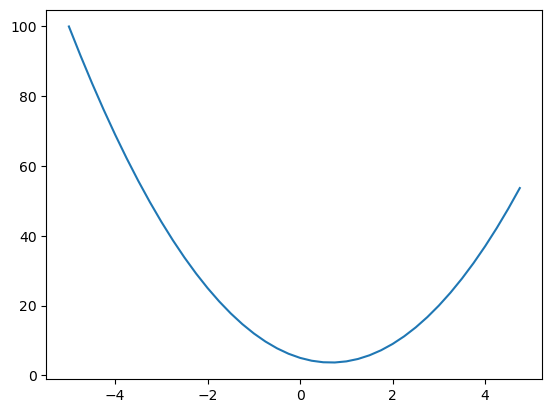

In [46]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [47]:
h = 0.00000000000001
x = 3.0
(f(x+h) - f(x))/h

14.210854715202004

In [48]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other): # other * self
        return self * other
    def __truediv__(self, other): # self / other
        return self * other**-1
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting power exponent as int or float for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        return out
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __radd__(self, other): # other + self
        return self + other
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [49]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

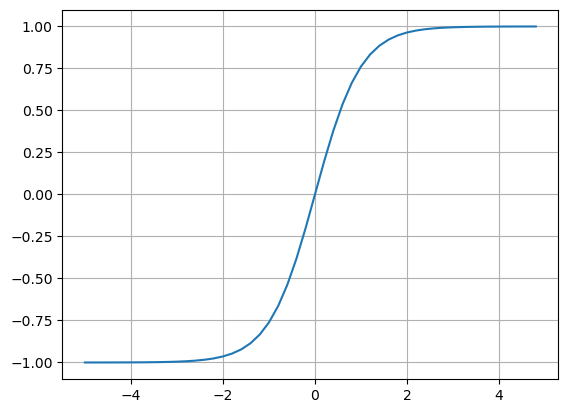

In [50]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

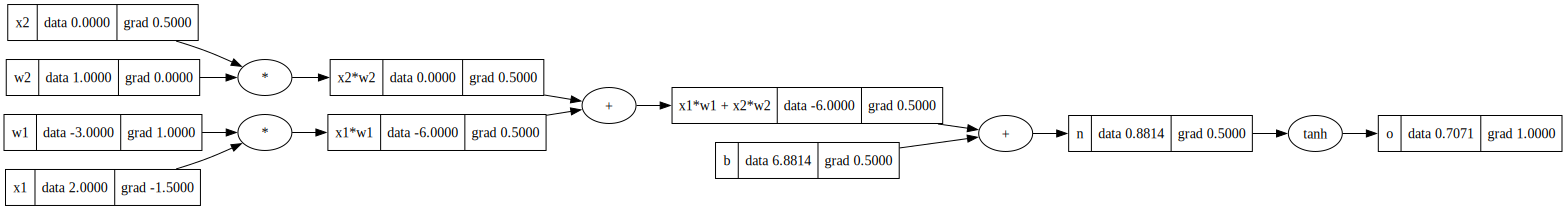

In [51]:


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

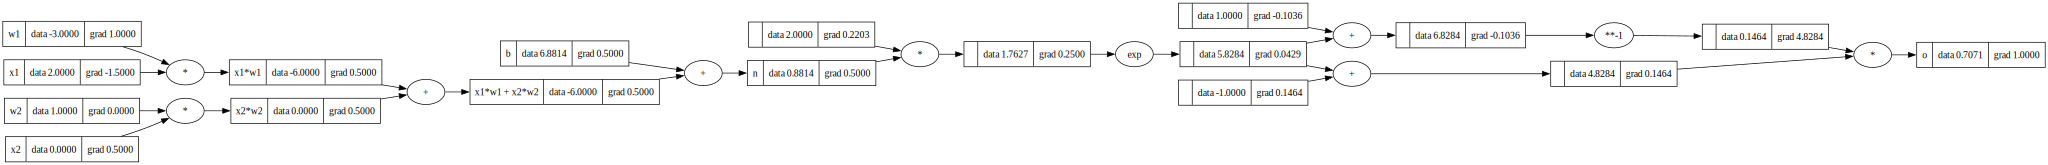

In [52]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

## ------------------------
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [53]:

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x): # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8820289082772733)

In [54]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8820289082772733),
 Value(data=-0.9859410442082022),
 Value(data=-0.9547633184888028),
 Value(data=-0.9777193122955995)]

In [55]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.455650501410426)

In [56]:
loss.backward()

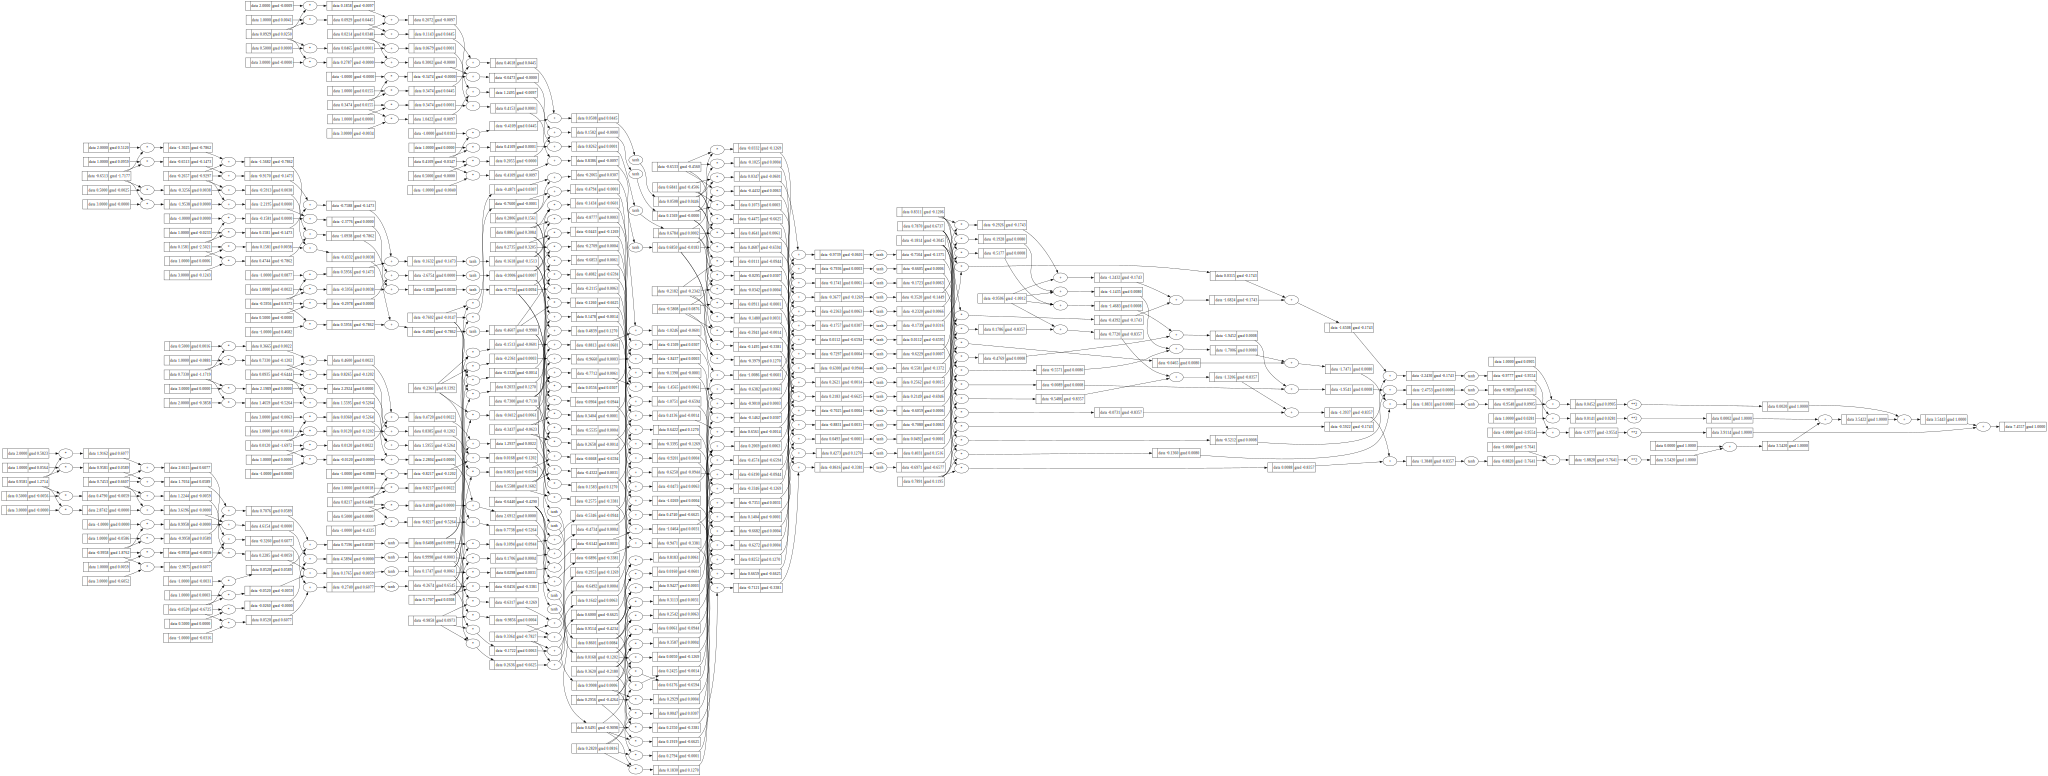

In [57]:
draw_dot(loss)

In [58]:
n.parameters()

[Value(data=0.9580829482648257),
 Value(data=-0.9958422862242837),
 Value(data=-0.0519992988029081),
 Value(data=0.745314054722058),
 Value(data=-0.6512593986703994),
 Value(data=0.15813146091607555),
 Value(data=-0.5955929653366772),
 Value(data=-0.2656924690974516),
 Value(data=0.7329620964152357),
 Value(data=0.012001230709160815),
 Value(data=0.8216523474043826),
 Value(data=0.09352783259960229),
 Value(data=0.09290404122108065),
 Value(data=0.34741081486731273),
 Value(data=0.4109184483549231),
 Value(data=0.021440741624029425),
 Value(data=-0.9857813060301355),
 Value(data=0.2735029265586828),
 Value(data=0.2955717863857201),
 Value(data=-0.653261665453591),
 Value(data=0.33641534194103406),
 Value(data=0.17066043298061184),
 Value(data=0.5588029546723416),
 Value(data=0.3619629397965234),
 Value(data=-0.21820792557928637),
 Value(data=-0.6439980931358249),
 Value(data=-0.7601879595555607),
 Value(data=-0.3436709606922572),
 Value(data=0.28197619835614507),
 Value(data=-0.5808393

In [59]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [60]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.130368760775228)

In [65]:
n_epochs = 20
lr = 0.05
for k in range(n_epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -lr * p.grad

    print(f"Epoch {k}: loss = {loss.data}")

Epoch 0: loss = 0.013401403850267377
Epoch 1: loss = 0.013031579918947975
Epoch 2: loss = 0.012681001221819147
Epoch 3: loss = 0.012348224613307927
Epoch 4: loss = 0.01203194652106655
Epoch 5: loss = 0.011730986565090733
Epoch 6: loss = 0.011444273421611865
Epoch 7: loss = 0.011170832582003106
Epoch 8: loss = 0.010909775717711009
Epoch 9: loss = 0.01066029141139515
Epoch 10: loss = 0.010421637054430773
Epoch 11: loss = 0.01019313174357275
Epoch 12: loss = 0.009974150036359791
Epoch 13: loss = 0.009764116446891402
Epoch 14: loss = 0.009562500581854821
Epoch 15: loss = 0.00936881283182282
Epoch 16: loss = 0.00918260054546367
Epoch 17: loss = 0.009003444624859844
Epoch 18: loss = 0.008830956488987712
Epoch 19: loss = 0.008664775359867666


In [66]:
ypred

[Value(data=0.962411429437202),
 Value(data=-0.9904716001975967),
 Value(data=-0.9487228700838686),
 Value(data=0.932681798392389)]